In [6]:
import matplotlib.pyplot as plt

In [7]:
a = 7

In [8]:
b = a + 3
b

10

Text(0.5, 1.0, 'Plot of b against a')

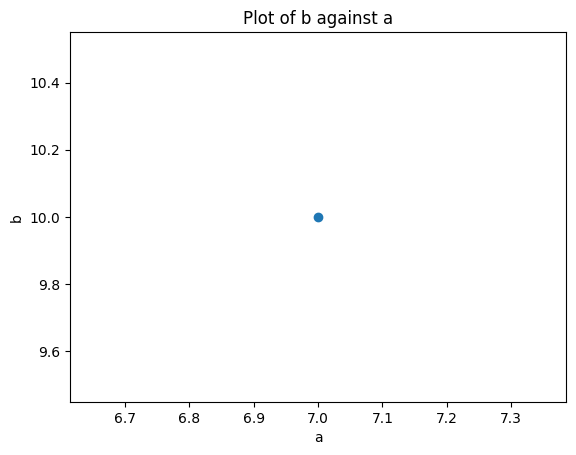

In [9]:
# Create the plot
fig, ax = plt.subplots()
ax.scatter(a, b)
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("Plot of b against a")